# In the name of God
# Machine Learning for Bioinformatics (Spring 1400)
# HW4 - CNN

# Student Info

## Full Name: Mahdi Kafi

## Student Number: 99210753

## Don't forget to change this file name to HW4_{student number}.ipynb


In [34]:
########################## P0 ##########################
# README                                               #
########################################################
# You must fill the parts like this that surrounded by comments
########################## END #########################

# Imports

In [35]:
RUN_LOCAL = False  # if you want to run this on colab, set this to False

In [36]:
# https://github.com/jacobgil/pytorch-grad-cam
if not RUN_LOCAL:
    !pip install grad-cam
    !pip install ttach

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
if not RUN_LOCAL:
    from google.colab import drive
from IPython import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image

# Configs

In [38]:
%matplotlib inline

In [39]:
BATCH_SIZE = 32
DATA_LOADER_KWARGS = {
    'batch_size': BATCH_SIZE, 
    'shuffle': True,
    'pin_memory': True,
    'num_workers': 0,
}

RGB_MEANS = [0.485, 0.456, 0.406]
RGB_STD = [0.229, 0.224, 0.225]

In [40]:
DEVICE = torch.device(torch.cuda.current_device()) if torch.cuda.is_available() else torch.device('cpu')
########################## P1 ##########################
# check if gpu is available then put DEVICE to cuda:0  #
# else DEVICE is equal to cpu.                         #
########################################################
########################## END #########################
DEVICE

device(type='cuda', index=0)

# Data

## Load from Google Drive (if you want to run code on colab)

First create a folder named "ML for Bio - Spring 1400" in your google drive root and copy the content of [this link](https://drive.google.com/drive/folders/1X53xvmmS3avr6py7Cf1LUq8DSA1EvNpC?usp=sharing) to it.

Make sure you do this correctly and the next cell runs with no error.

In [41]:
if not RUN_LOCAL:
    # Load data from google drive
    drive.mount('/content/drive', force_remount=True)

    # Don't change this, you must put the data here in your Google Drive
    FOLDERNAME = 'ML\ for\ Bio\ -\ Spring\ 1400/brain-tumor-dataset'

    %cd drive/My\ Drive
    %cp -r $FOLDERNAME ../../
    %cd ../../brain-tumor-dataset
    !unzip -q dataset.zip
    !rm dataset.zip
    %cd ..

Mounted at /content/drive
/content/drive/My Drive
/content/brain-tumor-dataset
replace no/no0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
/content


## Local Data

If you want to run the code locally, download the [dataset.zip](https://drive.google.com/file/d/158VyFbTPLHE_uN2yXvMtalSqdD2mdd5r/view?usp=sharing) and extract it in 'brain-tumor-dataset' folder besides your code. it must has a structure like below:

```
HW4_{student number}.ipynb
brain-tumor-dataset/
    no/
    yes/
```

## Create DataLoaders

In [42]:
transforms = [torchvision.transforms.Resize(256), torchvision.transforms.CenterCrop(224), torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(mean=RGB_MEANS, std=RGB_STD)]
########################## P2 ##########################
# Create a list of torchvision.transforms to:          #
# 1- Resize the image to 256x265 pixels                #
# 2- Center Crop the image to 224x224 pixels           #
# 3- Convert To Tensor                                 #
# 4- Normalize the tensor with RGB_MEANS and RGB_STD   #
########################################################
########################## END #########################
transforms = torchvision.transforms.Compose(transforms)

transforms

Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [43]:
train_dataset, val_dataset, test_dataset = None, None, None
all_dataset = torchvision.datasets.ImageFolder('brain-tumor-dataset', transform=transforms)
########################## P3 ##########################
# First split the all_dataset into three datasets with:#
# 70% Train, 20% Validation, 10% Test.                 #
# There is a function in torch.utils for this purpose. #
########################################################
val_size, test_size = .3, .1
num_train = len(all_dataset)
test_split = int(np.floor(test_size*num_train))
val_split = int(np.floor(val_size*num_train))
train_split = num_train - (test_split + val_split)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(all_dataset, [train_split, val_split, test_split])
########################## END #########################
train_loader = DataLoader(train_dataset, **DATA_LOADER_KWARGS)
val_loader = DataLoader(val_dataset, **DATA_LOADER_KWARGS)
test_loader = DataLoader(test_dataset, **DATA_LOADER_KWARGS)

print('Train Classes Dist:', np.bincount(np.array(all_dataset.targets)[train_dataset.indices]))
print('Val Classes Dist:  ', np.bincount(np.array(all_dataset.targets)[val_dataset.indices]))
print('Test Classes Dist: ', np.bincount(np.array(all_dataset.targets)[test_dataset.indices]))

Train Classes Dist: [873 927]
Val Classes Dist:   [462 438]
Test Classes Dist:  [165 135]


In [44]:
input_shape = tuple(all_dataset[0][0].shape)
num_classes = len(all_dataset.classes)

print('Input Shape =', input_shape)
print('Num of Classes =', num_classes)

Input Shape = (3, 224, 224)
Num of Classes = 2


## Visualizing

In [45]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor normalized image of size (C, H, W).
        Returns:
            Tensor: UnNormalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unnormalize = UnNormalize(RGB_MEANS, RGB_STD)

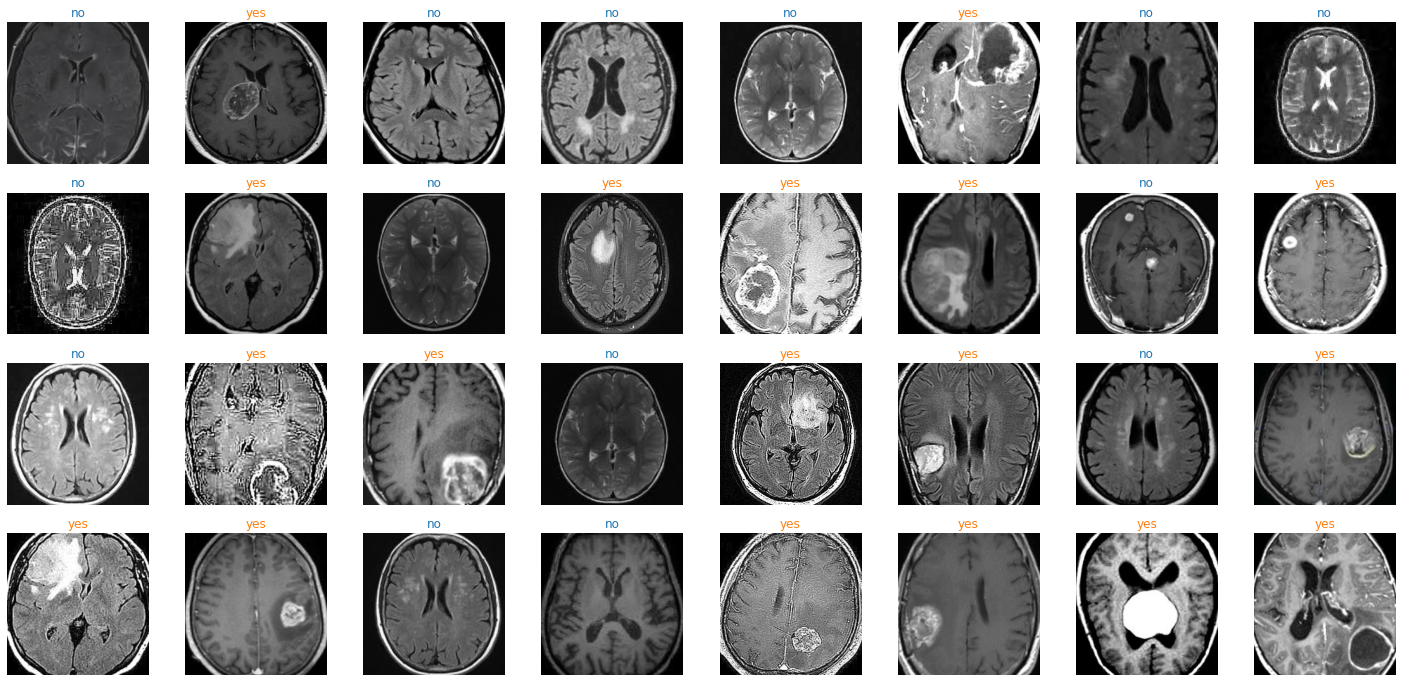

In [46]:
vis_num_images = 32
vis_images_per_row = 8

np.random.seed(6)
vis_image_indexes = np.random.choice(test_dataset.indices, size=vis_num_images, replace=False)
vis_images, vis_labels = [], []
for i in vis_image_indexes:
    new_image, new_label = all_dataset[i]
    vis_images.append(np.moveaxis(unnormalize(new_image).numpy(), 0, -1))
    vis_labels.append(new_label)

fig = plt.figure(figsize=(25, 12))
gs = fig.add_gridspec(int(np.ceil(vis_num_images / vis_images_per_row)), vis_images_per_row)

for i in range(vis_num_images):
    ax = fig.add_subplot(gs[i // vis_images_per_row, i % vis_images_per_row])
    ax.set_title(f'{all_dataset.classes[vis_labels[i]]}', c=f'C{vis_labels[i]}')
    ax.axis('off')
    ax.imshow(vis_images[i])

plt.show()

# Train & Test Methods

## Train

In [47]:
def train(model, train_loader, val_loader, optimizer, num_epochs=10):
    train_log = []
    test_log = []
    plt.figure(figsize=(16, 8))

    for epoch in range(1, num_epochs+1):
        train_loss = []
        model.train()
        for inputs, targets in tqdm(train_loader, desc='Training epoch ' + str(epoch), leave=False):        
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)        
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = model.get_loss(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        train_log.append(np.mean(train_loss))

        test_loss = []
        model.eval()
        with torch.no_grad():                
            for inputs, targets in tqdm(test_loader, desc='Validation', leave=False):         
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs)
                loss = model.get_loss(outputs, targets)
                test_loss.append(loss.item())
        test_log.append(np.mean(test_loss))

        plt.clf()
        plt.title(f'Epoch {epoch}/{num_epochs}')
        plt.plot(range(1, epoch+1), train_log, color='C0', label='Train')
        plt.plot(range(1, epoch+1), test_log, color='C1', label='Val')
        plt.legend()
        display.clear_output(wait=True)
        display.display(plt.gcf())

    plt.close()

## Test

In [48]:
def test(model, data_loader):
    y_true, y_pred = [], []

    with torch.no_grad():                
       for inputs, targets in tqdm(data_loader, desc='Predicting', leave=False):         
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            if type(outputs) is tuple: outputs = outputs[-1]
            outputs = outputs.detach().cpu().numpy()

            y_true += targets.detach().cpu().numpy().tolist()
            y_pred += np.argmax(outputs, axis=-1).tolist()

    print(classification_report(y_true, y_pred, target_names=all_dataset.classes))

# Model Definition

In [49]:
class ConvClassifier(nn.Module):
    def __init__(self, input_shape, num_classes, convs, fcs, conv_drop_rate=None, fc_drop_rate=None):
        """
        Args:
            input_shape: the dimension of the input image.
            num_classes: number of output classes.
            convs: it's 'vgg16' or a list of tuples with these info\:
                (out_channels, kernel_size, stride, padding, has_pooling), the first four are
                the configuration for creating a Conv2d layer and if has_pooling was True, you
                must add a MaxPool2d after the Conv2d.
            fcs: a list of integers representing number of Linear neurons in each layer
            conv_drop_rate: float(0-1), drop rate used for Conv2d layers
            fc_drop_rate: float(0-1), drop rate used for Linear layers
        """
        super(ConvClassifier, self).__init__()

        # Convolution Layers
        self.conv_layers = None
        if convs == 'vgg16':
            vgg16_pretrained = None
            ########################## P4 ##########################
            # set `vgg16_pretrained` to pretrained vgg16 model with#
            # batch normalization                                  #
            ########################################################
            vgg16_pretrained = torchvision.models.vgg16_bn(pretrained=True)
            ########################## END #########################
            self.conv_layers = vgg16_pretrained.features
        elif type(convs) is list:
            conv_layers = []
            ########################## P5 ##########################
            # for each item in `convs` add these 3-5 items to      #
            # `conv_layers`:                                       #
            # 1- nn.Conv2d                                         #
            # 2- nn.BatchNorm2d                                    #
            # 3- nn.ReLU                                           #
            # 4- nn.Dropout if `conv_drop_rate` is not None        #
            # 5- nn.MaxPool2d(2, 2) if has_pooling is True         #
            ########################################################
            for idx, item in enumerate(convs):
                if idx == 0:
                    conv_layers.append(nn.Conv2d(in_channels=input_shape[0], out_channels=item[0], kernel_size=item[1], stride=item[2], padding=item[3]))
                else:
                    conv_layers.append(nn.Conv2d(in_channels=convs[idx-1][0], out_channels=item[0], kernel_size=item[1], stride=item[2], padding=item[3]))
                conv_layers.append(nn.BatchNorm2d(item[0]))
                conv_layers.append(nn.ReLU())
                if conv_drop_rate:
                    conv_layers.append(nn.Dropout2d(conv_drop_rate))
                if item[4]:
                    conv_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            ########################## END #########################
            self.conv_layers = nn.Sequential(*conv_layers)
        else:
            raise Exception(f'Wrong value for parameter `convs`: {convs}')
        # Get the output shape of last conv layer
        convs_output_shape = self.conv_layers(torch.randn(1, *input_shape)).shape[1:]
        # Fully Connected Layers
        fc_layers = []
        ########################## P6 ##########################
        # first add a nn.Flatten to `fc_layers` then for each  #
        # value in `fcs` add these 3-4 items to `fc_layers`:   #
        # 1- nn.Linear                                         #
        # 2- nn.BatchNorm1d                                    #
        # 3- nn.ReLU                                           #
        # 4- nn.Dropout if `fc_drop_rate` is not None          #
        # in the end add a nn.Linear for the final output with #
        # `num_classes` neurons and a nn.Softmax after it.     #
        ########################################################
        fc_layers.append(nn.Flatten())
        for idx, num in enumerate(fcs):
            if idx == 0:
                fc_layers.append(nn.Linear(in_features=512*7*7, out_features=num))
            else:
                fc_layers.append(nn.Linear(in_features=fcs[idx-1], out_features=num))
            fc_layers.append(nn.BatchNorm1d(num_features=num))
            fc_layers.append(nn.ReLU())
            if fc_drop_rate:
                fc_layers.append(nn.Dropout(fc_drop_rate))
        fc_layers.append(nn.Linear(in_features=fcs[-1], out_features=num_classes))
        fc_layers.append(nn.Softmax())
        ########################## END #########################
        self.fc_layers = nn.Sequential(*fc_layers)

        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, x):
        output = None
        ########################## P7 ##########################
        # generate the output using created variables.         #
        ########################################################
        output = self.fc_layers(self.conv_layers(x))
        ########################## END #########################
        return output

    def get_loss(self, outputs, targets):
        loss = None
        ########################## P8 ##########################
        # calculate the loss using `self.cross_entropy`        #
        ########################################################
        loss = self.cross_entropy(outputs, targets)
        ########################## END #########################
        return loss

# Vanilla VGG16 (no pretrain)

## Create Model

In [50]:
vgg16 = None
########################## P9 ##########################
# By using the `ConvClassifier` class create vgg16.    #
# in this part you must write the layers specifications#
# yourself (use convs = list of tuples).               #
# Change the drop rates to get best result in 10 epochs#
########################################################
vgg16 = ConvClassifier(input_shape=input_shape, num_classes=num_classes, convs=[(64, 3, 1, 1, False), (64, 3, 1, 1, True), (128, 3, 1, 1, False), (128, 3, 1, 1, True), (256, 3, 1, 1, False), (256, 3, 1, 1, False), (256, 3, 1, 1, True), (512, 3, 1, 1, False), (512, 3, 1, 1, False), (512, 3, 1, 1, True), (512, 3, 1, 1, False), (512, 3, 1, 1, False), (512, 3, 1, 1, True)], 
                       fcs=[4096, 4096], conv_drop_rate=.1, fc_drop_rate=.3)
########################## END #########################

vgg16.to(DEVICE)
vgg16

ConvClassifier(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout2d(p=0.1, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Dropout2d(p=0.1, inplace=False)
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU()
    (16): Dropout2

## Train

In [51]:
optimizer = torch.optim.Adam(vgg16.parameters(), lr=1e-3)

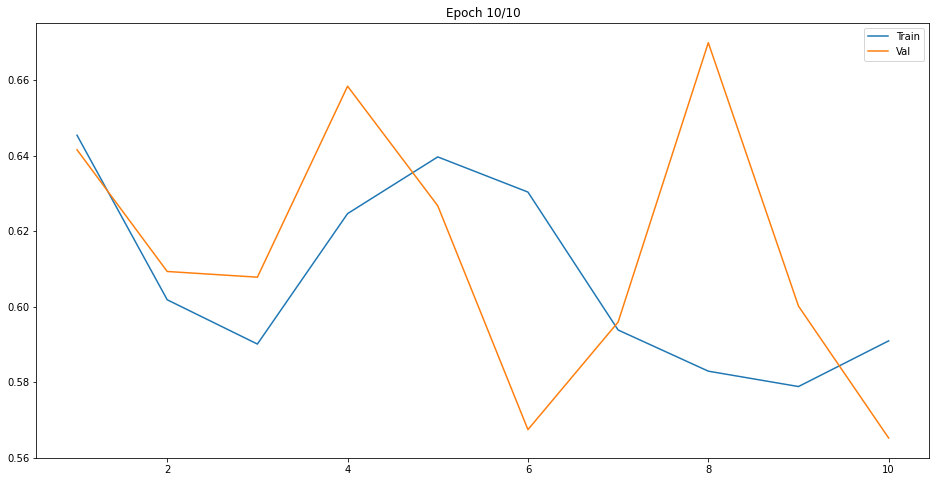

In [52]:
train(vgg16, train_loader, val_loader, optimizer, num_epochs=10)

## Test

In [53]:
test(vgg16, train_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


              precision    recall  f1-score   support

          no       0.78      0.72      0.75       873
         yes       0.76      0.81      0.78       927

    accuracy                           0.77      1800
   macro avg       0.77      0.77      0.77      1800
weighted avg       0.77      0.77      0.77      1800



In [54]:
test(vgg16, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


              precision    recall  f1-score   support

          no       0.76      0.70      0.73       462
         yes       0.71      0.77      0.74       438

    accuracy                           0.73       900
   macro avg       0.74      0.74      0.73       900
weighted avg       0.74      0.73      0.73       900



In [55]:
test(vgg16, test_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


              precision    recall  f1-score   support

          no       0.82      0.70      0.76       165
         yes       0.69      0.81      0.74       135

    accuracy                           0.75       300
   macro avg       0.75      0.76      0.75       300
weighted avg       0.76      0.75      0.75       300



## CAM (Class Activation Map)

In [56]:
def CAM(model, target_layer):
    fig = plt.figure(figsize=(25, 12))
    gs = fig.add_gridspec(int(np.ceil(vis_num_images / vis_images_per_row)), vis_images_per_row)
    ########################## P10 #########################
    # Create the same grid of images as "Visualizing" part #
    # but you must add CAM overlay to them too. use        #
    # `GradCAMPlusPlus` and `show_cam_on_image` for this.  #
    #######################################################
    cam = GradCAMPlusPlus(model, target_layer)
    vis_images, vis_labels = [], []
    for i in vis_image_indexes:
        new_image, new_label = all_dataset[i]
        new_image_cam = new_image.reshape((1, 3, 224, 224))
        grayscale_cam = cam(input_tensor=new_image_cam.to(DEVICE), target_category=new_label)
        grayscale_cam = grayscale_cam[0, :]
        showing_image = np.moveaxis(unnormalize(new_image).numpy(), 0, -1)
        vis = show_cam_on_image(showing_image, grayscale_cam)
        vis_images.append(vis)
        vis_labels.append(new_label)

    for i in range(vis_num_images):
        ax = fig.add_subplot(gs[i // vis_images_per_row, i % vis_images_per_row])
        ax.set_title(f'{all_dataset.classes[vis_labels[i]]}', c=f'C{vis_labels[i]}')
        ax.axis('off')
        ax.imshow(vis_images[i])

    ########################## END #########################
    plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/pytorch_grad_cam/base_cam.py:85: RuntimeWarning: invalid value encountered in true_divide
  img = img / np.max(img)


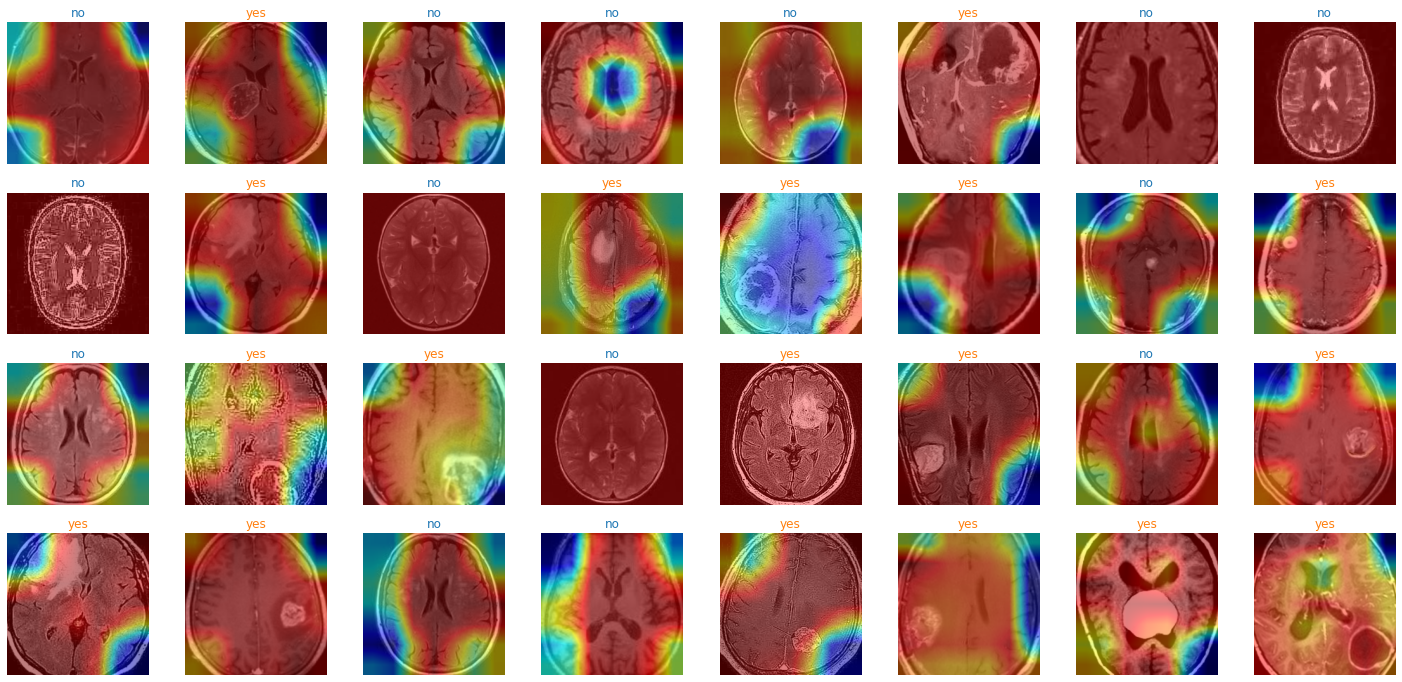

In [57]:
CAM(vgg16, vgg16.conv_layers[-1])

# Transfer Learning

## Create Model

In [58]:
vgg16_imagenet = None
########################## P11 #########################
# Like "P9" but use convs = 'vgg16' this time.           #
########################################################
vgg16_imagenet = ConvClassifier(input_shape=input_shape, num_classes=num_classes, convs='vgg16', 
                       fcs=[4096, 4096], conv_drop_rate=.1, fc_drop_rate=.5)
########################## END #########################

vgg16_imagenet.to(DEVICE)
vgg16_imagenet

ConvClassifier(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): C

## Train

In [59]:
########################## P12 #########################
# Change the Learning Rate and compare the results.    #
# write your observation and its reasons in the next   #
# cell.                                                #
########################################################
optimizer = torch.optim.Adam(vgg16_imagenet.parameters(), lr=1e-4)
########################## END #########################

P12 Answer:<br>


* learning_rate = 1e-3: train loss = 0.5, val_loss = 0.65
* learning_rate = 1e-2: train loss = 0.8, val_loss = 0.76
* learning_rate = 1e-1: train loss = 0.82, val_loss = 0.82 
* learning_rate = 1e-4: train loss = 0.33, val_loss = 0.33
 
<div dir="rtl">
* هنگامیکه میزان لرنینگ ریت، بالا داده می‌شود باعت می‌شود که وزن‌های شبکه از قبل آموزش دیده به مقدار زیادی تغییر کنند و در بهینه سازی تابع هزینه به مشکل بربخوریم و وزن‌های مناسبی که در شبکه وجود داشت را به وزن‌های نامناسبی تبدیل کنیم، که همانطور که دیده می‌شود اگر این پارامتر برابر با ۰.۱ قرار بگیرد باعت می‌شود که مقدار هزینه بسیار بالا برود. اما اگر این مقدار را کم انتخاب کنیم به طور مثال برابر با ۰.۰۰۰۱ بگذاریم دیده می‌شود که شبکه بسیار خوب عمل می‌کند و این به دلیل آن است که وزن‌های مناسب شبکه را فقط به مقدار کمی برای اینکه کمی برای داده‌های خودمان مناسب‌تر بشود، تغییر می‌دهیم.
</div>

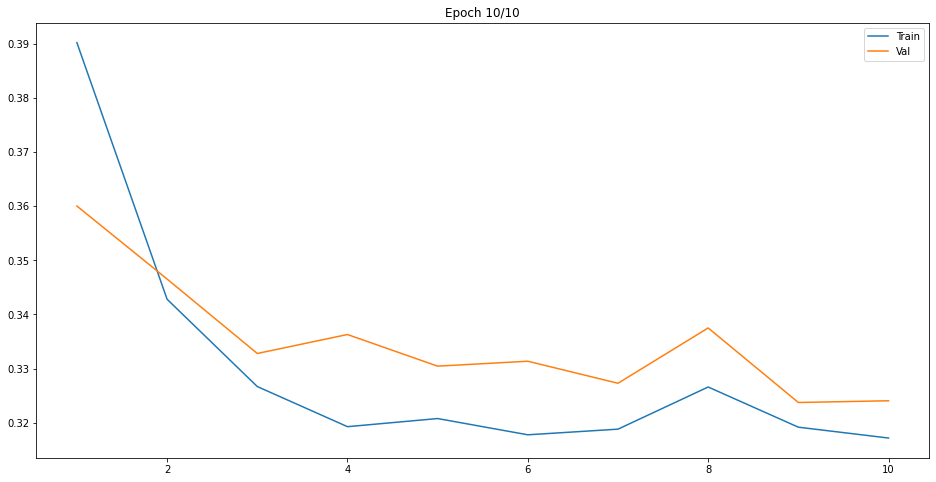

In [60]:
train(vgg16_imagenet, train_loader, val_loader, optimizer, num_epochs=10)

## Test

In [61]:
test(vgg16_imagenet, train_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


              precision    recall  f1-score   support

          no       1.00      1.00      1.00       873
         yes       1.00      1.00      1.00       927

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



In [62]:
test(vgg16_imagenet, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


              precision    recall  f1-score   support

          no       0.99      0.99      0.99       462
         yes       0.99      0.99      0.99       438

    accuracy                           0.99       900
   macro avg       0.99      0.99      0.99       900
weighted avg       0.99      0.99      0.99       900



In [63]:
test(vgg16_imagenet, test_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


              precision    recall  f1-score   support

          no       0.99      0.98      0.99       165
         yes       0.98      0.99      0.99       135

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



## CAM (Class Activation Map)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/pytorch_grad_cam/base_cam.py:85: RuntimeWarning: invalid value encountered in true_divide
  img = img / np.max(img)


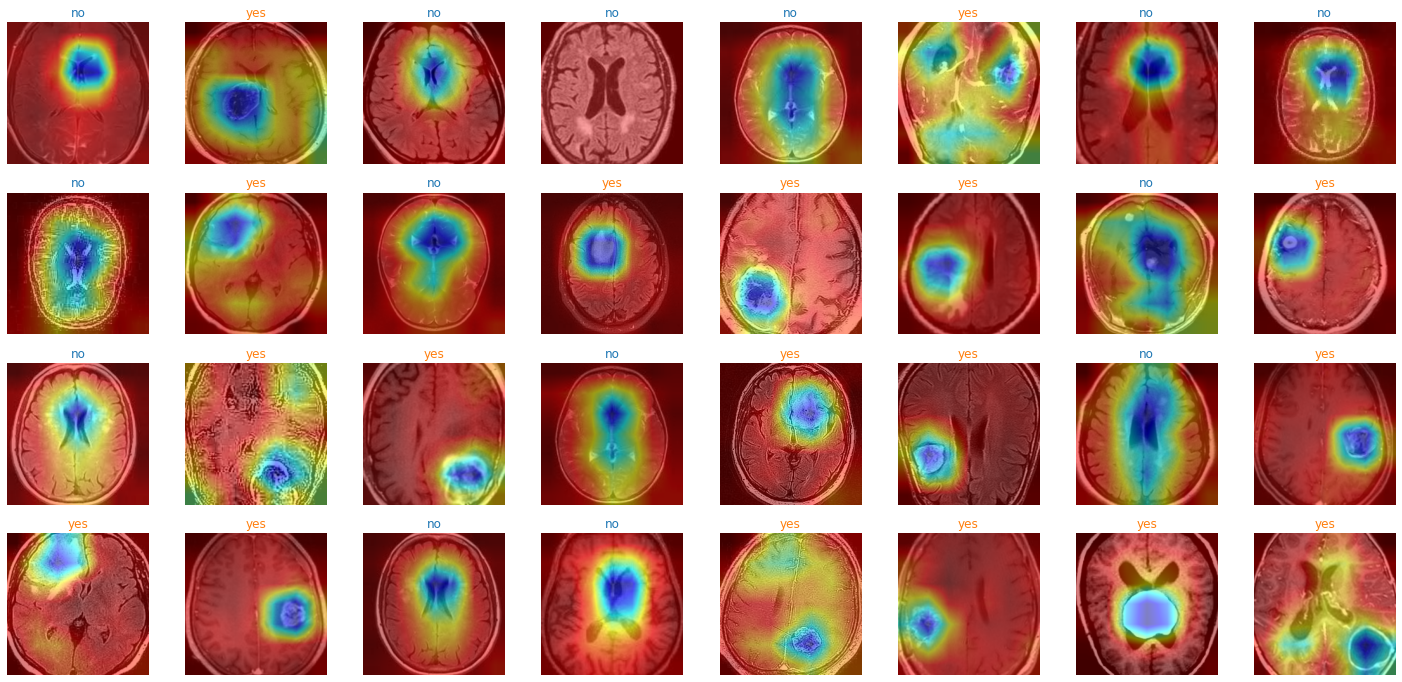

In [64]:
CAM(vgg16_imagenet, vgg16_imagenet.conv_layers[-1])

# Questions
Answer the following questions:

## P13:
<div dir="rtl">
دلایلی که باعث بهبود نتیجه با استفاده از Transfer Learning شده‌اند، چیست؟
</dir>

<div dir="rtl">
* با استفاده از Transfer Learning، وزن‌های ابتدایی شبکه وزن‌های مناسبی هستند و هنگامیکه در شروع آموزش وزن‌های بهتری داشته‌باشیم، باعث می‌شود که به نتیجه‌ بهتری برسیم در پایان آموزش در مقایسه با حالتیکه با وزن‌های تصادفی شروع به آموزش بکنیم.
<br>
* دلیل دیگری که باعث شد، شبکه بهتر عمل بکند، این است که داده ما به مقدار کافی برای آموزش این شبکه نبود و با استفاده از شبکه از پیش آموزش دیده توانستیم که از تعداد بسیار زیاد داده‌ای که این شبکه برای روی آن‌ها آموزش دیده‌است نیز بهر ببریم.
<br>
* دلایلی که باعث بهبود عملکرد شبکه شدند، در بالا گفته‌شدند و به صورت کلی دلایلی که باعث می‌شوند از Transfer Learning استفاده کنیم، این است که همانند بالا هم باعث می‌شود شروع بهتری داشته‌باشیم و هم با داده کمتر بتوانیم نتیجه بهتری بگیریم و هم اینکه باعث می‌شود بتوانیم با سرعت بسیار بیشتری مدل‌هایمان را آموزش بدهیم زیرا که مدل از پیش آموزش خوبی دیده‌است و همینطور به دقت بهتری خواهیم رسید.
</div>

## P14:

<div dir="rtl">
با توجه به خروجی CAM، آیا شبکه به قسمت درستی از عکس نگاه میکند؟ در هر یک از لیبل‌های yes و no شبکه به کجای عکس نگاه می‌کند؟
</div>

<div dir="rtl">
با استفاده از مدل از قبل آموزش دیده، شبکه با دقت خوبی به بخش درستی از تصاویر نگاه می‌کند. به طور مثال دیده‌ می‌شود که در تصاویری که لیبل yes دارند، دقیقا به تومور نگاه می‌کند. ولی در تصاویری که لیبل no دارند می‌توان گفت که به تمام تصویر نگاه می‌کند ولی به بخش‌هایی شبیه به تومور هستند و رنگ روشنی دارند و حالت مدور دارند بیشتر نگاه می‌کند. 
</div>